In [1]:
from spatial_aggregation import disaggregate_polygon_to_raster, aggregate_raster_to_polygon
from plot import plot_raster, plot_vector

import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
import numpy as np
import rasterio as rio

In [2]:
path_total_demand = "data/annual-heat-demand-twh.csv"
path_electricity = "data/annual-heat-electricity-demand-twh.csv"
path_spatial_units_national = "data/units_national.geojson"
path_spatial_units_regional = "data/units.geojson"
path_populations = "build/population-europe.tif"


In [3]:
# total_demand = pd.read_csv(path_total_demand)
electricity = pd.read_csv(path_electricity, index_col=[0,1,2,3])
spatial_units_national = gpd.read_file(path_spatial_units_national).set_index("id")
# spatial_units_regional = gpd.read_file(path_spatial_units_regional).set_index("id")
populations = rioxarray.open_rasterio(path_populations) #, chunks="auto")
import rasterio as rio

# # load raster data
with rio.open(path_populations) as file:
    raster_data = file.read()
    transform = file.transform
    crs = file.crs
    populations = xr.DataArray(raster_data).squeeze()
    # Add crs and transform as metadata
    populations.attrs['transform'] = transform
    populations.attrs['crs'] = crs
    populations.dims

# alternative way of loading raster data
# populations = rioxarray.open_rasterio(path_populations).
# transform = Affine.from_gdal(*populations.attrs["transform"])
# rename dims
# populations = populations.rename({"dim_1":"x", "dim_2":"y"})
# populations = populations.coarsen(x=100, y=100, boundary="trim").mean()
populations = populations.rio.set_spatial_dims(x_dim="dim_2", y_dim="dim_1")

In [ ]:
populations.plot(vmin=0, vmax=100, cmap="Blues")

In [5]:
from rasterio.warp import reproject, calculate_default_transform

def reproject_raster_data(src, dst_crs):
    # calculate the transform matrix for the output
    dst_transform, width, height = calculate_default_transform(
        src.crs,    # source CRS
        dst_crs,    # destination CRS
        src.width,    # column count
        src.height,  # row count
        *src.bounds(),  # unpacks outer boundaries (left, bottom, right, top)
    )

    dst_kwargs = {}  #src.rio.meta.copy()
    dst_kwargs.update(
        {
            "crs": dst_crs,
            "transform": dst_transform,
            "width": width,
            "height": height,
            "nodata": 0,  # replace 0 with np.nan
        }
    )

    return reproject(
        source=src,
        destination=np.empty(src.shape),
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        # resampling=Resampling.nearest,
    )
    

populations_reprojected, transform = reproject_raster_data(populations, "epsg:4326")

AttributeError: 'DataArray' object has no attribute 'arr'

In [55]:
populations.__dir__()

['T',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__dask_graph__',
 '__dask_keys__',
 '__dask_layers__',
 '__dask_optimize__',
 '__dask_postcompute__',
 '__dask_postpersist__',
 '__dask_scheduler__',
 '__dask_tokenize__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__'

In [46]:
populations_reprojected.plot(cmap="Blues", vmin=0, vmax=200)

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [28]:
populations_reprojected.rio.crs

AttributeError: 'numpy.ndarray' object has no attribute 'rio'

In [ ]:
raster = populations
crs = "EPSG:4326"
nodata = "255"
kwargs = {}
kwargs.get("nodata", 255)
reprojected = reproject(
    source=raster,
    destination=np.empty(raster.shape),
    src_crs=raster.rio.crs,
    dst_crs=crs,
    # src_transform=raster.rio.transform,
    # dst_transform=raster.rio.transform,
    # dst_nodata=nodata
)
reprojected

    # return rio.warp.reproject(
    #     masked,
    #     empty(shape),
    #     src_crs=raster.crs,
    #     dst_crs=crs,
    #     src_transform=transform_,
    #     dst_transform=transform,
    #     dst_nodata=nodata,
    # )

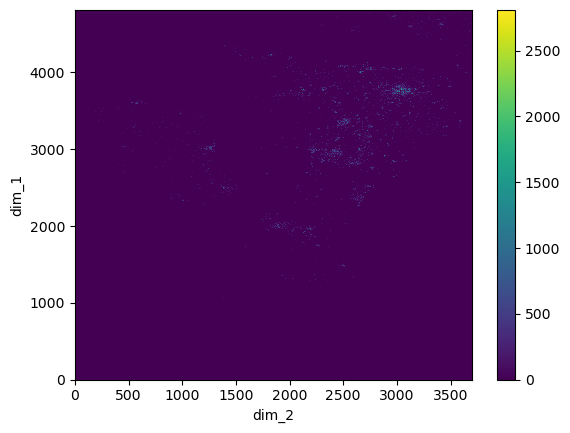

In [8]:
fig, ax = plt.subplots()
populations.plot()
# ax.set_ylim(35, 70)
# ax.set_xlim(-100, 100)

In [ ]:

# join statistical data with polygon geometries
electricity = pd.merge(electricity, spatial_units_national, left_on="country_code", right_on="id")
electricity = gpd.GeoDataFrame(electricity, geometry="geometry")

# plot statistical data and proxies
# plot_vector(electricity, column="value", cmap="Reds", legend=True)
plot_raster(populations, cmap="Blues", vmin=0, vmax=100, alpha=0.2, projection="EPSG:4326")
plt.savefig("build/electricity.png")